# South Australia Solar Supply Forecast

---

As South Australia progresses toward its 100% renewable energy target by 2030, having robust forecasting tools becomes ever more critical to maintain reliability as dependency on solar/wind increases. This project aims to forecast energy supply from solar photovoltaic (PV) in South Australia; a crucial step toward shaping sustainable energy strategies for the region.

### Data Source

Our data is collected with [OpenNEM API](https://opennem.org.au/) and [Open Meteo API](https://open-meteo.com/), made available under [CC BY 4.0 License](https://creativecommons.org/licenses/by/4.0/).

### Analysis Tool

We will be using Python 3 (Numpy, Pandas, Matplotlib) and [Nixtla's StatsForecast](https://nixtlaverse.nixtla.io/statsforecast/) library in this project.

---

## Importing File

We import the file `extracted.csv` which is extracted from OpenNEM and Open Meteo's API. The extracting script can be found as `script_etl.py` on the same folder, which samples the daily data from 5 January 2019 to 5 January 2024 for various solar plants in South Australia.

/home/rotisayabundar/.local/lib/python3.8/site-packages/statsforecast/core.py:25: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


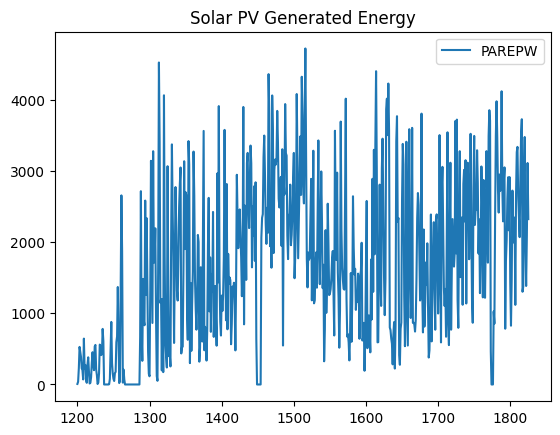

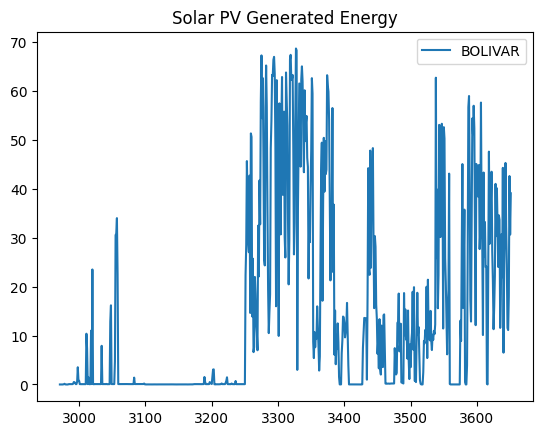

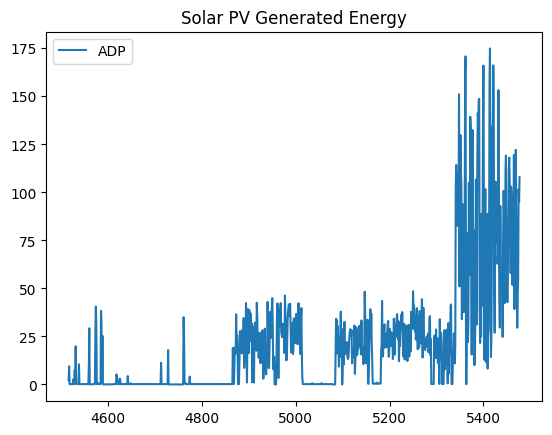

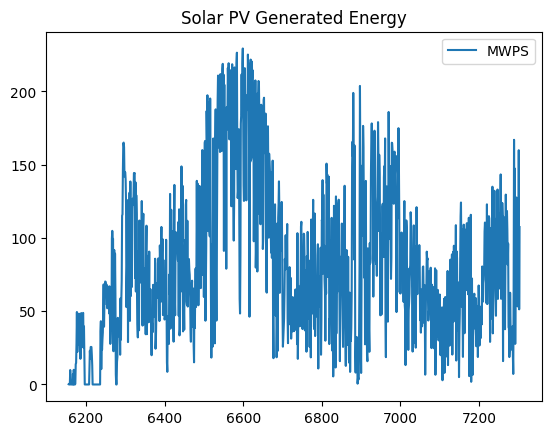

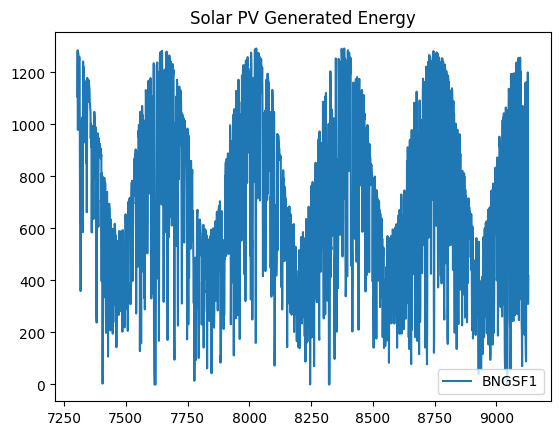

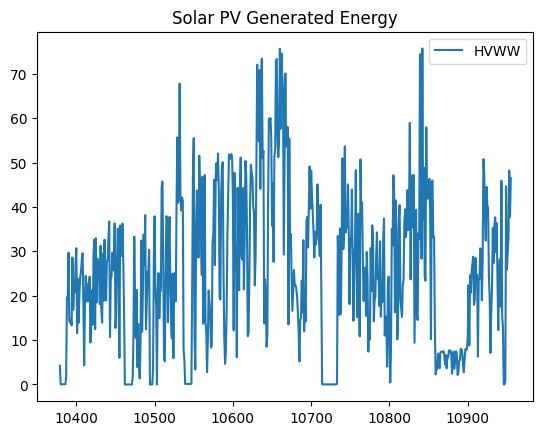

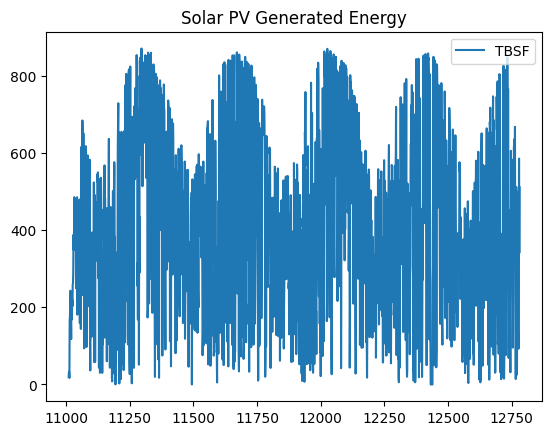

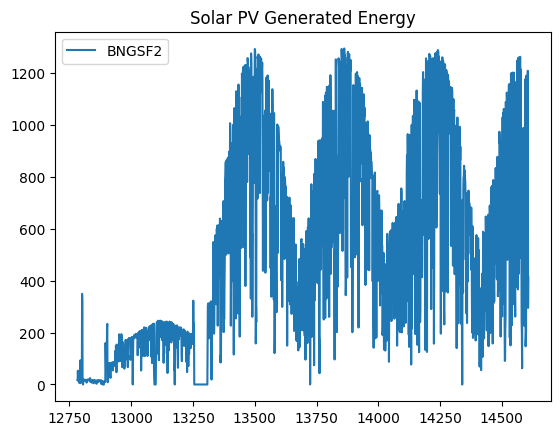

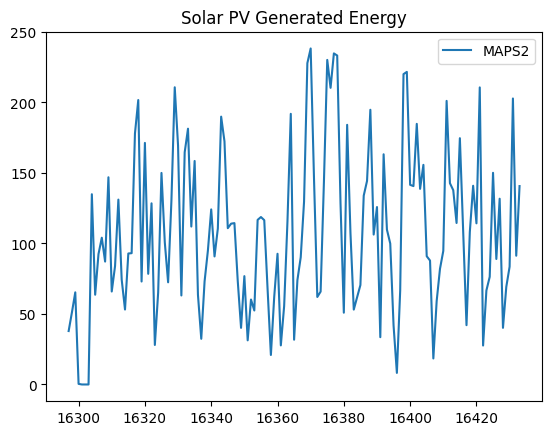

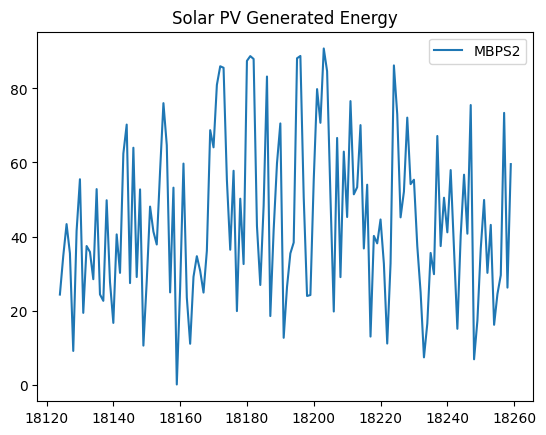

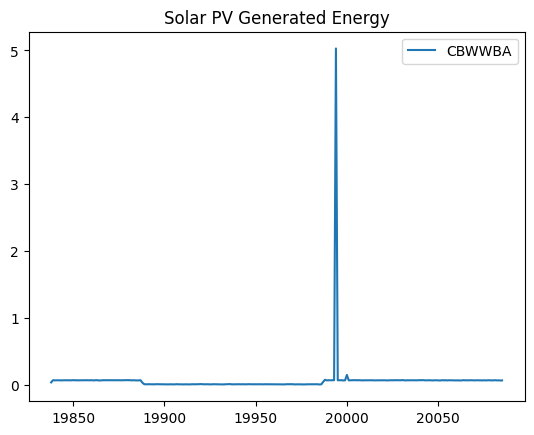

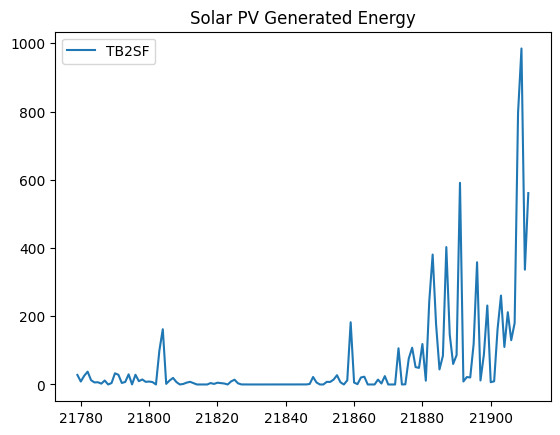

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoTheta, WindowAverage

from os.path import isfile
import pickle
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mse

# Import data
sol = pd.read_csv("sol_data.csv")

# Select the data from establishment dates (actually should be in ETL)
for name in sol["Name"].unique():
    start_date_idx = sol[sol["Name"] == name].index[0]
    est_date_idx = sol[(sol["Name"] == name) & (sol["Energy"] > 0)].index[0]
    sol.drop(index = list(range(start_date_idx, est_date_idx)), inplace=True)

# Preview plot
for name in sol["Name"].unique():
    plt.close()
    plt.plot(sol[sol["Name"] == name]["Energy"], label=name)
    plt.title("Solar PV Generated Energy")
    plt.legend()
    plt.show()

## Time Series Modeling

We will use several time series models such as ARIMA, Theta model, as well as baseline model such as Window Average in the last seven days. Other possible updates include Croston model if the series is sparse.

With the ARIMA model, we incorporate temperature and solar irradiance as exogenous factors.

We use RMSE as accuracy metrics for our model, and pick the best model for each solar plant location in South Australia.

In [2]:
# === Model

# Change header for modelling library
sol_sf = sol[["Name", "Date", "Energy", "Temperature", "Solar Irradiance"]] \
                .replace("", np.nan).dropna() \
                .rename(columns = {
                    "Name": "unique_id",
                    "Date": "ds",
                    "Energy": "y"
                })

models = [AutoARIMA(), AutoTheta(), WindowAverage(7)]
sf = StatsForecast(models, freq="D", df=sol_sf)

In [3]:
# === Cross-validation

# Based on short vs long time series
# For simplicity, load the objects from Pickle

ds_counts = sol_sf.groupby("unique_id").size()
ds_count_limit = 500
sol_sf_filter = sol_sf["unique_id"].isin(ds_counts[ds_counts > ds_count_limit].index)
sol_sf_long = sol_sf[sol_sf_filter]
sol_sf_short = sol_sf[-sol_sf_filter]
if not isfile("save_model.pkl"):
    cv_sol_sf_long = sf.cross_validation(df=sol_sf_long, h=7, n_windows=5, step_size = 100)
    cv_sol_sf_short = sf.cross_validation(df=sol_sf_short, h=7, n_windows=10, step_size = 10)
    with open('save_model.pkl', 'wb') as outp:
        pickle.dump(cv_sol_sf_long, outp, pickle.HIGHEST_PROTOCOL)
        pickle.dump(cv_sol_sf_short, outp, pickle.HIGHEST_PROTOCOL)
else:
    with open('save_model.pkl', 'rb') as inp:
        cv_sol_sf_long = pickle.load(inp)
        cv_sol_sf_short = pickle.load(inp)

print(cv_sol_sf_long)
print(cv_sol_sf_short)

                           ds              cutoff           y   AutoARIMA  \
unique_id                                                                   
ADP       2022-11-23 04:00:00 2022-11-22 04:00:00    0.192000    0.248272   
ADP       2022-11-24 04:00:00 2022-11-22 04:00:00    0.192000    0.344183   
ADP       2022-11-25 04:00:00 2022-11-22 04:00:00    0.192000    0.577914   
ADP       2022-11-26 04:00:00 2022-11-22 04:00:00    0.192000    0.293433   
ADP       2022-11-27 04:00:00 2022-11-22 04:00:00    0.192000    0.247278   
...                       ...                 ...         ...         ...   
TBSF      2023-12-30 04:00:00 2023-12-27 04:00:00  145.399994  261.927917   
TBSF      2023-12-31 04:00:00 2023-12-27 04:00:00   92.879997  528.012268   
TBSF      2024-01-01 04:00:00 2023-12-27 04:00:00  302.200012  430.936249   
TBSF      2024-01-02 04:00:00 2023-12-27 04:00:00  585.599976  475.466858   
TBSF      2024-01-03 04:00:00 2023-12-27 04:00:00  341.000000  203.770493   

In [4]:
# === Accuracy

def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) # Averages the error metrics for all cutoffs for every combination of model and unique_id
    evals['best_model'] = evals.idxmin(axis=1)
    return evals

# RMSE. AIC, BIC soon

model_error_sol_sf_long = evaluate_cross_validation(cv_sol_sf_long.reset_index(), mse)
model_error_sol_sf_short = evaluate_cross_validation(cv_sol_sf_short.reset_index(), mse)
print(model_error_sol_sf_long)
print(model_error_sol_sf_short)

              AutoARIMA     AutoTheta  WindowAverage     best_model
unique_id                                                          
ADP        6.994745e+02  6.695463e+02   9.903906e+02      AutoTheta
BNGSF1     6.730339e+04  1.087701e+05   9.678183e+04      AutoARIMA
BNGSF2     5.226248e+04  8.441254e+04   7.477876e+04      AutoARIMA
BOLIVAR    2.202686e+02  3.147788e+02   2.065522e+02  WindowAverage
HVWW       2.491005e+02  5.714313e+02   4.768101e+02      AutoARIMA
MWPS       1.569240e+03  3.242798e+03   3.002580e+03      AutoARIMA
PAREPW     1.012210e+06  1.044142e+06   1.190892e+06      AutoARIMA
TBSF       5.370759e+04  7.044920e+04   7.508467e+04      AutoARIMA
              AutoARIMA     AutoTheta  WindowAverage best_model
unique_id                                                      
CBWWBA         0.385784      0.369293       0.408800  AutoTheta
MAPS2       3109.616455   4962.395996    4520.651367  AutoARIMA
MBPS2        486.488281    548.817261     566.807312  AutoARIMA


In [5]:
# Collect final predictions
pred_list = []
for col, row in pd.concat([model_error_sol_sf_long, model_error_sol_sf_short]).iterrows():
    loc_str = col
    best_model_str = row["best_model"]
    best_model_class = globals()[row["best_model"]]
    best_model = best_model_class() if best_model_str != "WindowAverage"  else best_model_class(7)
    sol_sf_loc = sol_sf[sol_sf["unique_id"] == loc_str]
    best_sf = StatsForecast([best_model], freq="D", df=sol_sf_loc[:-7])
    pred = best_sf.forecast(7, df=sol_sf_loc[:-7], X_df = sol_sf_loc[-7:].drop("y", axis=1))
    pred.columns.values[1] = "y"
    pred_list.append(pred)
preds = pd.concat(pred_list)
hists = sol_sf

## Visualisation

Note that the prediction is currently for up to 7 days based on historical data, so in general forecasts for later days are less accurate than the early ones.

In [21]:
# === Basic visualisation

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"

def sol_points(unique_id):
    curr_hists = hists[hists["unique_id"] == unique_id]
    curr_preds = preds[preds.index == unique_id]
    return(dict(x = [curr_hists["ds"][-30:-7], curr_hists["ds"][-8:], pd.concat([curr_hists["ds"][-8:-7], curr_preds["ds"]])],
                y = [curr_hists["y"][-30:-7], curr_hists["y"][-8:], pd.concat([curr_hists["y"][-8:-7], curr_preds["y"]])],
                visible = True))

curr_loc = "ADP"
curr_sol_points = sol_points(curr_loc)
fig = go.Figure()
fig.add_trace(go.Scatter(x = curr_sol_points["x"][0], y = curr_sol_points["y"][0], mode='lines', name = "Historic"))
fig.add_trace(go.Scatter(x = curr_sol_points["x"][1], y = curr_sol_points["y"][1], mode='lines', name = "Actual"))
fig.add_trace(go.Scatter(x = curr_sol_points["x"][2], y = curr_sol_points["y"][2], mode='lines', name = "Forecast"))
fig.update_layout(barmode = 'overlay', template = "plotly_white")
fig.update_layout(
    updatemenus = [dict(direction = "down",
                        buttons = [dict(args=[sol_points(loc)],
                                        label=loc,
                                        method="restyle") for loc in sol["Name"].unique()],
                        pad = {"r": 10, "t": 10}, showactive =True,
                        x = 0.11, xanchor="left", y = 1.1, yanchor = "top")]
)
fig